In [18]:
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import re

from langdetect import detect
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift, estimate_bandwidth, SpectralClustering, AffinityPropagation
from sklearn.metrics import silhouette_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

## Unsupervised Learning Capstone

The goal for this project is to exercise and apply unsupervised learning techniques. To do this we are going to use spacys' unsupervised neural networks and word vector library to generate document vectors for each song in our data set. Then we are going to use supervised classifiers on our vectors to classify which genre a lyric comes from. Also we will use various clustering methods from sci kit learn to see if we can find any hiden data structure in our document vectors. We will also look at genre counts for each cluster to see if our clustering algorithims are picking up on the song genre, if they are not picking up on the genre labels then we will test the clusters across samples to see if they are consistant in the unlabeled data structures they find.

In [2]:
df = pd.read_csv('lyrics.csv')
df.head()

,index,song,year,artist,genre,lyrics
0,0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu..."
1,1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy,\nit's like you see..."
2,2,honesty,2009,beyonce-knowles,Pop,If you search\nFor tenderness\nIt isn't hard t...
3,3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote..."
4,4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po..."


In [3]:
df.shape

(362237, 6)

In [4]:
df.isnull().sum()

index         0
song          2
year          0
artist        0
genre         0
lyrics    95680
dtype: int64

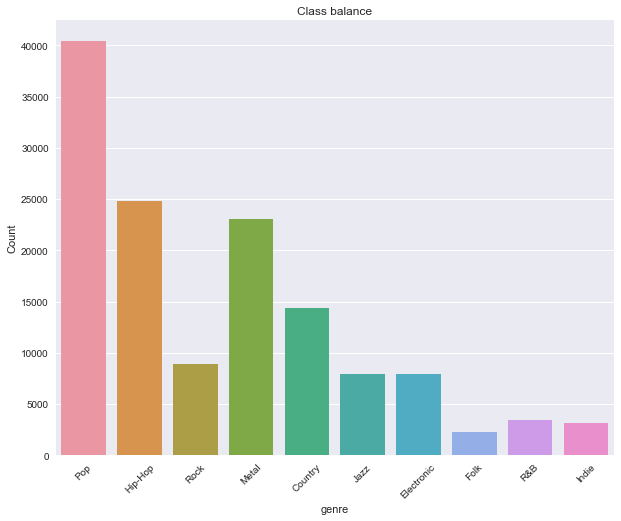

total observations: 136192


In [5]:
#Cleaning text, This should catch a lot of things spacys neural networks don't.
def text_cleaner(text):
    text = re.sub(r'--',' ',text)
    # Get rid of headings in square brackets.
    text = re.sub("[\[].*?[\]]", "", text)
    # Get rid of \n.
    text = re.sub(r"\n", " ", text)
    # Get rid of extra whitespace.
    text = ' '.join(text.split())
    return text

df.dropna(inplace=True)
df.lyrics = df.lyrics.apply(text_cleaner)

#Droping all rows with null values, the 10,000 rows with out lyrics can't be used
#and the two rows with out song ids won't be missed
#Also droping rows where lyrics were missing, but not NAN, and Rows where genre is not available/other
df.dropna(inplace=True)
df.drop((df[df.genre == 'Not Available'].index),inplace=True, axis=0)
df.drop((df[df.genre == 'Other'].index),inplace=True, axis=0)
df.drop((df[df.lyrics.str.len() < 1].index), inplace=True, axis=0)

#Class balance is way off undersampling rock which represents about a third of our data set
rock_index = df[df.genre == 'Rock'].index
#select rows to drop
random_indices = np.random.choice(rock_index, 105000, replace=False)
#drop selected rows
df.drop(random_indices, inplace=True, axis=0)

#for now reducing data set to 10,000 to save time
#df = df.sample(50000, random_state=42)
#df.reset_index(inplace=True, drop=True)
#df.drop('index', inplace=True, axis=1)

plt.figure(figsize=(10,8))
plt.title('Class balance')
sns.countplot(x="genre", data=df)
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

print('total observations:', df.shape[0])

In [6]:
#Language detection was out of the scope of this project so we're just doing a quick and dirty clean up
#with pythons' langdetect package. Droping all rows where language was not english.
def detect_try(text):
    try:
        return detect(text)
    except:
        return 'error'

#Language column
df['language'] = df.lyrics.apply(detect_try)
print(df.language.value_counts())

#droping language column and rows that aren't english
df.drop((df[df.language != 'en'].index), inplace=True, axis=0)
df.drop('language', inplace=True, axis=1)

df.shape

en       124143
es         3840
de         1756
fr         1138
id          960
it          795
ro          732
pt          447
tr          245
no          241
sw          241
nl          238
fi          201
sv          198
tl          157
so          103
hr           96
hu           92
sq           88
error        85
cy           71
da           67
ca           64
af           56
pl           51
et           26
sl           24
lt           19
vi            8
sk            4
cs            3
lv            2
ja            1
Name: language, dtype: int64


(124143, 6)

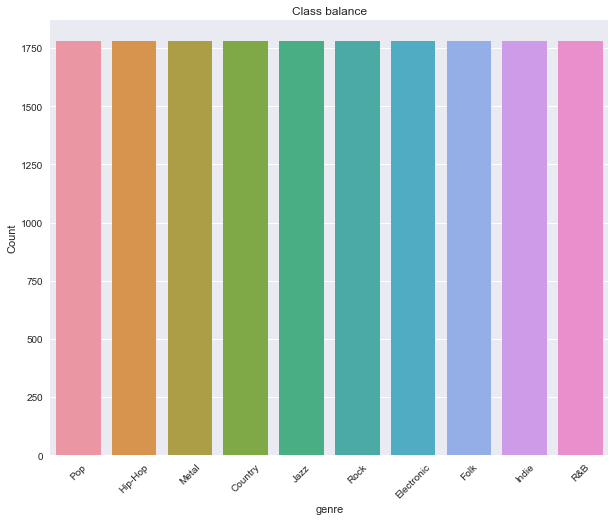

total observations: 17800


In [7]:
#Fixing class balance with undersampling
indices_to_drop = []

for X in df.genre.unique():
    #get all indices for X genre
    indices_x = df[df.genre == X].index
    #how many to drop
    num = len(indices_x) - (df.genre.value_counts().min())
    #randomly select indeces to drop
    random_indices = list(np.random.choice(indices_x, num, replace=False))
    indices_to_drop += random_indices
    
df.drop(indices_to_drop, inplace=True, axis=0)
    
plt.figure(figsize=(10,8))
plt.title('Class balance')
sns.countplot(x="genre", data=df)
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

print('total observations:', df.shape[0])
print('Per Class:', df.shape[0] / 10)

In [8]:
#removing chained assignment warning
pd.options.mode.chained_assignment = None

#method for getting Lemmas from our Spacy Docs for TFIDF
def doc2lemmas(nlpdoc):
    doc = []
    for token in nlpdoc:
        if token.lemma_ == '-PRON-':
            doc.append(token.text)
        elif token.is_punct:
            pass
        else:
            doc.append(token.lemma_)
    doc = ' '.join(doc)
    return doc


#This spacy model has 1.1 million word embeddings that will help us generate our doc vectors.
#Get vectors
nlp = spacy.load('en_vectors_web_lg')
vectors = [] 

for doc in nlp.pipe(iter(df['lyrics']),batch_size=256):
    vectors.append(doc.vector)

#Get lemmas
nlp = spacy.load('en')
sentences = []

for doc in nlp.pipe(iter(df['lyrics']),batch_size=256):
    sentences.append(doc2lemmas(doc))

#column of lemmas
df['lemmas'] = sentences
df.lemmas.head()

##Create vector DF and concat to our original DF
vector_df = pd.DataFrame(vectors)
vector_df.reset_index(drop=True, inplace=True)
df.reset_index(drop=True, inplace=True)
df = pd.concat([df, vector_df], axis=1)

In [9]:
df.lemmas.head(2)

0    oh oh oh I oh oh oh I if I write a book about ...
1    party the people the people the party it be po...
Name: lemmas, dtype: object

In [10]:
df.lyrics.head(2)

0    Oh oh oh I, oh oh oh I If I wrote a book about...
1    Party the people, the people the party it's po...
Name: lyrics, dtype: object

In [11]:
def model_support(clf, X_train, y_train, X_test, y_test, X_train_tfidf, X_test_tfidf):
    clf.fit(X_train, y_train)
    print(clf.score(X_train, y_train), ':word embedings train score')
    print(clf.score(X_test, y_test), ':word embedings test score')
    clf.fit(X_train_tfidf, y_train)
    print(clf.score(X_train_tfidf, y_train), ':tfidf w/ LSA train score')
    print(clf.score(X_test_tfidf, y_test), ':tfidf  w/ LSA test score')


#Transform lemmas into TF-IDF
vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=2, stop_words='english',
    lowercase=True, use_idf=True,norm=u'l2',
    smooth_idf=True
)
X_tfidf = vectorizer.fit_transform(df.lemmas)

#Latent Semantic Analysis on TF-IDF
svd = TruncatedSVD(500)
X_tfidf = svd.fit_transform(X_tfidf)

#word2vec Data
X = df.loc[:,~df.columns.isin(['index', 'song', 'year', 'artist', 'genre', 'lyrics', 'lemmas'])]
y = df.loc[:,'genre']

#Split embeddings and tfidf with same random seed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)
X_train_tfidf, X_test_tfidf = train_test_split(X_tfidf, test_size=0.20, stratify=y, random_state=42)

In [13]:
svc = LinearSVC(C=1, random_state=42)

model_support(svc, X_train, y_train, X_test, y_test, X_train_tfidf, X_test_tfidf)

0.4434691011235955 :word embedings train score
0.39353932584269663 :word embedings test score
0.45568820224719103 :tfidf w/ LSA train score
0.3724719101123595 :tfidf  w/ LSA test score


In [14]:
gbc = GradientBoostingClassifier(max_depth=6, n_estimators=100, learning_rate=.1)

model_support(gbc, X_train, y_train, X_test, y_test, X_train_tfidf, X_test_tfidf)

0.9948033707865168 :word embedings train score
0.3901685393258427 :word embedings test score
0.9725421348314607 :tfidf w/ LSA train score
0.35280898876404493 :tfidf  w/ LSA test score


In [15]:
knn = KNeighborsClassifier(n_neighbors=9, weights='distance')

model_support(knn, X_train, y_train, X_test, y_test, X_train_tfidf, X_test_tfidf)

0.9973314606741573 :word embedings train score
0.31797752808988766 :word embedings test score
0.9969803370786516 :tfidf w/ LSA train score
0.2601123595505618 :tfidf  w/ LSA test score


In [16]:
lr = LogisticRegression(C=5)

model_support(lr, X_train, y_train, X_test, y_test, X_train_tfidf, X_test_tfidf)

0.44592696629213485 :word embedings train score
0.40224719101123596 :word embedings test score
0.46390449438202247 :tfidf w/ LSA train score
0.3797752808988764 :tfidf  w/ LSA test score


In [19]:
mlp = MLPClassifier(hidden_layer_sizes=(155,), max_iter=400)

model_support(mlp, X_train, y_train, X_test, y_test, X_train_tfidf, X_test_tfidf)

0.7177668539325842 :word embedings train score
0.38679775280898876 :word embedings test score
0.994311797752809 :tfidf w/ LSA train score
0.3654494382022472 :tfidf  w/ LSA test score


In [108]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
X_pca = np.hstack((X_pca, y[:,None]))
#from sklearn.preprocessing import LabelEncoder
#enc = LabelEncoder()
#y_num = enc.fit_transform(y)
#X_pca = np.hstack((X_pca, y_num[:,None]))

X_pca = pd.DataFrame(X_pca, columns=['PCA Feature 1', 'PCA Feature 2', 'genre'])

In [111]:
pca.explained_variance_

array([0.18262718, 0.10687937])

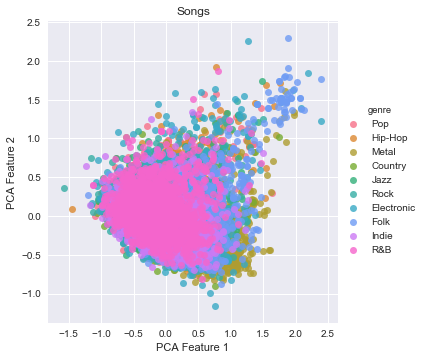

In [129]:
#plot data with seaborn
sns.lmplot(data=X_pca, x='PCA Feature 1', y='PCA Feature 2', hue='genre', fit_reg=False)
plt.title('Songs')
plt.show()

In [136]:
from sklearn.cluster import MeanShift, estimate_bandwidth, SpectralClustering, AffinityPropagation
from sklearn.metrics import silhouette_score

bandwidth = estimate_bandwidth(X, quantile=.3, n_samples=1000, random_state=42)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)

labels = ms.labels_
len(np.unique(labels))

2

In [148]:
from sklearn.cluster import SpectralClustering

n_clusters=10

sc = SpectralClustering(n_clusters=n_clusters)
sc.fit(X)

predict=sc.fit_predict(X)

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y, predict))
print('Counts for each clsuter label in order:', np.unique(predict, return_counts=True)[1])

Comparing the assigned categories to the ones in the data:
col_0         0    1    2    3    4    5    6    7    8    9
genre                                                       
Country     170  286   53   75  159  235  124  306  167  205
Electronic  198  232   46  269  186  204  129  231  183  102
Folk        199  106   56  209   68  153   78  216  393  302
Hip-Hop      31   56  735   83  181   32  333   80   45  204
Indie       212  264   26   74  145  284   84  299  239  153
Jazz        149  225   58  143  228  195  166  263  159  194
Metal       292   86   19  178   48  145   41  147  695  129
Pop         141  357   58  122  289  204  195  230  100   84
R&B         110  314   51  111  355  170  265  209   90  105
Rock        212  244   42  113  161  244  139  244  229  152
Counts in for each clsuter label in order: [1714 2170 1144 1377 1820 1866 1554 2225 2300 1630]


In [150]:
from sklearn.metrics import adjusted_rand_score
    
adjusted_rand_score(y, predict)

0.04080770339988055

In [149]:
from sklearn.cluster import AffinityPropagation

af = AffinityPropagation().fit(X)

cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labels = af.labels_

print('number of clusters: {}'.format(n_clusters_))

Done
Estimated number of clusters: 868
